# Modeling Error Benchmark for the Linear SPR
This benchmark attempts to evaluate how the different inverse techniques for the LinearSourcePathReceiver behave when there are modeling errors in the frequency response functions (FRFs) for the force estimation. This type of error is common in both MIMO vibration testing [dabornes paper] and TPA [maartens paper], where the system that is used to derive the FRFs does not exactly match the system that was used to generate field data. 

This benchmark uses two versions of a stacked-beam system, which are referred to as system A and system B. These beam systems are shown in Figure 1 and Figure 2, respectively.  

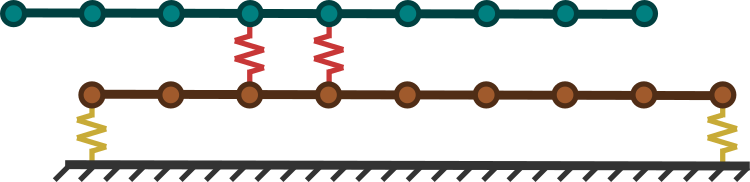  
**Figure 1:** Benchmark System A

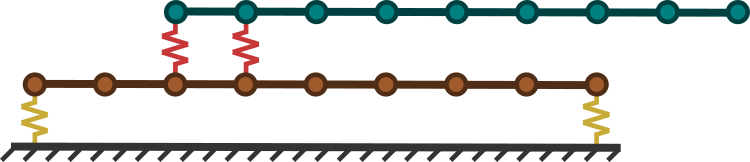  
**Figure 2:** Benchmark System B

The beam systems are composed of four components:
1. The source beam - this is the brown line and dots in the figures
2. The receiver beam - this is the turquoise line and dots in the figures
3. The ground springs - these are the yellow springs that connect the beam to ground
4. The connector springs - these are the red springs that connect the source and receiver beams to each other

The general process for this benchmark is as follows:
1. Target responses will be generated for both system A and B in the "nominal" configuration.
2. A "modified" configuration will be made for system A that includes different forms of modeling error.
2. Pseudo-forces will be estimated with the different inverse methods using FRFs from the modified configuration of system A. There are two benchmark quantities of interest (QoIs) at this step:
    - Reconstructed response accuracy to the training response
    - Force amplitude
3. The pseudo-forces from system A will be applied to system B to compute a predicted response. There is one benchmark QoI at this step:
    - Predicted response accuracy to the target response

In [1]:
import numpy as np
import sdynpy as sdpy
import forcefinder as ff
from linear_spr_modeling_error_benchmark_utilities import (compute_benchmark_system_time_response,
                                                           create_beam_system_a_ise_frfs,
                                                           create_beam_system_b_ise_frfs,
                                                           phase_referenced_spectra,
                                                           rms_asd_error_octaves,
                                                           compute_spectrum_rms,
                                                           dof_averaged_rms_level_error,
                                                           create_beam_systems,
                                                           create_small_beam_systems)
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import itertools

## Generate the Target Responses
This section uses the pre-made functions in the `benchmark_system_generation` module to compute the target responses for the benchmarking. The truth responses are computed using time integration with broadband random excitation applied to all the DOFs on the source beam, as shown in Figure 3. The same forces are applied to both system A and system B, where the straight arrows indicate a translating force DOF and the circular arrows indicate and moment DOF. Note that the random excitation is created using a NumPy random number generator with the `normal` method. A constant seed (42 in the NumPy `default_rng` function) was used, to ensure consistent benchmark results over multiple runs.

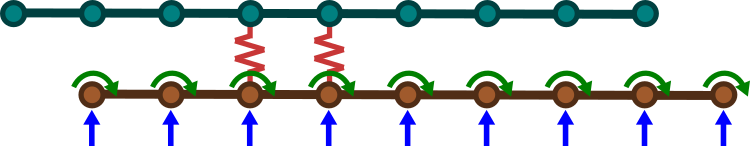  
**Figure 3:** Force DOFs for computing the truth responses

Note that the responses are computed for a subset of the response DOFs on the receiver beams for system A and system B, as shown in Figures 4 and 5.

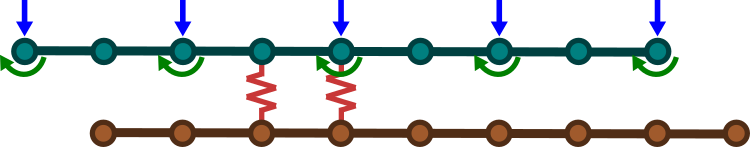  
**Figure 4:** Response DOFs on system A

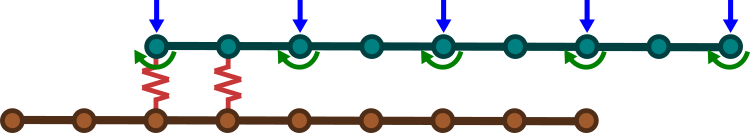  
**Figure 5:** Response DOFs on system B

### Modeling Information for the Nominal Configuration
The source and receiver beams are the exact same in the nominal configuration, meaning that the only difference between the systems is the connection degrees of freedom (DOFs) between the beams. The beams were modeled using Euler-Bernouli beam finite element techniques that exist and SDynPy [Dans paper]. The beams are two dimensional and only use shear and moment DOFs. As implied by the figures, the beams are comprised of eight elements each with each dot being a node in the model. The various model properties for the different components are:

- **Beam Properties:**
  - Length - 4 m
  - Width - 0.02 m 
  - Heigh - 0.015 m
  - Elastic Modulus - 69.8e9 pa
  - Density - 2,700 kg/m<sup>3</sup>
  - Poissons Ratio - 0.33
  - Damping - ~2% damping ratio, set by modal damping (this is the damping at the beam level, not the system level)

- **Ground Spring Properties:**
  - Translating Stiffness - 1e9 N/m
  - Angular Stiffness - 1e2 Nm/rad

- **Connector Spring Properties:**
  - Translating Stiffness - 1e9 N/m
  - Angular Stiffness - 0.11e3 Nm/rad

In [2]:
random_excitation, system_a_time_response, system_b_time_response = compute_benchmark_system_time_response()

### Computing the Frequency Domain Response
The frequency domain response was computed as a "phase referenced spectra", where the phase of the referenced signal is subtracted from the phase of the response signal. In this case, a force signal from the `random_excitation` variable was used as a phase reference to ensure a consistent reference between the system A and B response (this is required for pseudo-forces that are transferable system-system). The signal processing parameters for computing the spectra were:
- Block Time: 5 s
- Overlap: 50%
- Window: Hanning
- Number of Averages: 100

In [3]:
system_a_response = phase_referenced_spectra(system_a_time_response, random_excitation[0])
system_b_response = phase_referenced_spectra(system_b_time_response, random_excitation[0])

## Generating the FRFs for Source Estimation
The frequency response functions (FRFs) for the pseudo-force estimation use references at the connector spring DOFs on the source beam, as shown in Figure 7. Note that the SPR objects are set to have a minimum frequency of 1 Hz because the elastic net algorithm will not converge at 0 Hz. 

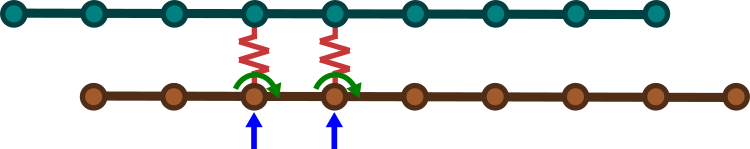  
**Figure 7:** Force DOFs for estimating the pseudo-forces

### Simulating Modeling Errors
Modeling errors were simulated on system A using the following techniques:
1. The locations of the nodes on the beams are slightly perturbed to simulate slight changes in the measurement locations.
2. The material properties of the beams are slightly perturbed.
3. The stiffness properties of the connector spring are slightly perturbed.

In [4]:
perturbed_beam_properties = {'youngs_modulus': 69.8e9*1.05, # pascals
                             'density': 2700*1.1, # kg/m^3
                             'poissons_ratio': 0.33*.95,
                             'translating_interface_spring': 1e9*1.5, #N/m
                             'torsion_interface_spring': 0.11e3*0.8, #Nm/rad
                             'beam_damping_ratio': 0.012} #ratio

_, system_a_truth, _, system_b_truth = create_small_beam_systems()
_, system_a_model, _, _ = create_beam_systems(**perturbed_beam_properties)

system_a_truth_modes = system_a_truth.eigensolution(maximum_frequency=0.5/system_a_time_response.abscissa_spacing)
system_a_model_modes = system_a_model.eigensolution(maximum_frequency=0.5/system_a_time_response.abscissa_spacing)

In [5]:
system_a_model_coordinate = sdpy.coordinate_array(node=np.array([202, 210, 222, 230, 240, 250, 262, 272, 280])[...,np.newaxis], direction=[3,5]).flatten()
system_a_truth_coordinate = sdpy.coordinate_array(node=np.array([201, 202, 203, 204, 205, 206, 207, 208, 209])[...,np.newaxis], direction=[3,5]).flatten()

<Axes: xlabel='Shape Number', ylabel='Shape Number'>

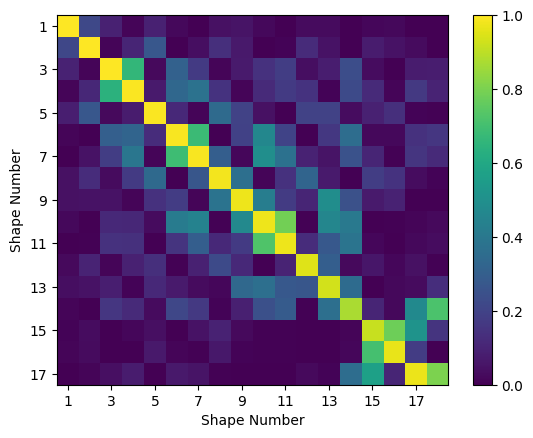

In [6]:
system_a_mac = sdpy.correlation.mac(system_a_truth_modes[system_a_truth_coordinate].T, system_a_model_modes[system_a_model_coordinate].T)
sdpy.correlation.matrix_plot(system_a_mac, display_values=None)

In [7]:
print(sdpy.shape.shape_comparison_table(system_a_truth_modes[:17], system_a_model_modes[:17],
                                        percent_error_format='{:0.2f}%'))

  Mode  Freq 1 (Hz)  Freq 2 (Hz)  Freq Error  Damp 1  Damp 2  Damp Error  MAC
     1         1.29         1.25       3.01%   0.88%   0.53%      66.05%   11
     2         3.16         3.08       2.68%   0.54%   0.32%      67.60%   30
     3         4.14         4.03       2.63%   1.80%   1.08%      66.44%    5
     4         8.67         8.45       2.58%   1.80%   1.08%      66.68%    2
     5        15.10        14.73       2.50%   1.87%   1.12%      66.64%   11
     6        22.24        21.67       2.66%   1.84%   1.11%      66.60%    0
     7        30.29        29.49       2.69%   1.89%   1.14%      66.71%    3
     8        37.27        36.20       2.97%   1.82%   1.09%      66.68%    8
     9        51.16        49.59       3.17%   1.87%   1.12%      66.73%    1
    10        53.68        51.93       3.38%   1.92%   1.15%      66.67%    1
    11        72.05        69.42       3.78%   1.95%   1.17%      66.62%    2
    12        90.98        87.35       4.16%   1.97%   1.18%    

In [8]:
system_a_ise_frfs = create_beam_system_a_ise_frfs(abscissa=system_a_response.ravel().abscissa[0], **perturbed_beam_properties)
system_b_ise_frfs = create_beam_system_b_ise_frfs(abscissa=system_a_response.ravel().abscissa[0])

system_a_spr = ff.LinearSourcePathReceiver(system_a_ise_frfs, system_a_response)
system_a_spr.extract_elements_by_abscissa(min_abscissa=1)

system_b_spr = ff.LinearSourcePathReceiver(system_b_ise_frfs, system_b_response)
system_b_spr.extract_elements_by_abscissa(min_abscissa=1)

'LinearSourcePathReceiver object with 4 reference coordinates, 10 target response coordinates, and 10 training response coordinates'

## Benchmarks
This section computes the benchmark metrics for all the inverse methods in LinearSourcePathReciever of ForceFinder, as listed in the `benchmark_register` dictionary. Note that the problem form may influence the results of the benchmarks, notably:
- Auto-Tikhonov by K-fold Cross Validation - The low number of training response DOFs in the benchmark problem mean that there will only be two response DOFs in each fold. The low number of response DOFs per folds causes this method to be under-determined, which is different than all the other inverse methods. It should also be noted that the folds are decided at random, meaning that repeated runs of this test will result in slightly different estimated forces.
- Elastic Net by Information Criterion - The problem force does not include any redundant force DOFs in the pseudo-force estimation. This introduces a bias against the elastic net since it is a sparse solver that will attempt to eliminate redundant force DOFs. Further, the elastic net requires the tuning of the "alpha parameter" to achieve the best results. This parameter was not tuned for this problem.

As previously mentioned this benchmark evaluates the inverse methods with two QoIs:
1. Reconstructed response (i.e., the response computed from the pseudo-forces)
2. Force Amplitude

The metrics to evaluate the reconstructed response QoI are:
1. The "rms_asd_error". This method converts the reconstructed and truth spectra in the SPR objects to PSD format in octave bands (instead of the native narrowband), computes the dB PSD error for every training response DOF, the computes a single error spectrum by computing the RMS of the PSD error over all the response DOFs (on a frequency-frequency basis). Note that the rms_asd_error is plotted in 1/3 octave frequency format to make the plot less cluttered. 
2. The dB error for the RMS value in the reconstructed and training responses.  

The force amplitude QoI is evaluated by comparing the force RMS level for each DOF. 

In [9]:
benchmark_register = {'Manual Inverse': ('manual_inverse', {}),
                      'Tikhonov with L-curve': ('auto_tikhonov_by_l_curve', {}),
                      'TSVD with L-curve': ('auto_truncation_by_l_curve', {}), 
                      'Tikhonov with Leave-one-out Cross Validation': ('auto_tikhonov_by_cv_rse', {'cross_validation_type':'loocv'}), 
                      'Tikhonov with K-fold Cross Validation': ('auto_tikhonov_by_cv_rse', {'cross_validation_type':'k-fold', 'number_folds':5}),
                      'Elastic Net with AICC': ('elastic_net_by_information_criterion', {'alpha_parameter':0.5})}

In [10]:
inverse_method_names = []
rms_asd_error_a = []
rms_level_error_a = []
force_rms_level = []
rms_asd_error_b = []
rms_level_error_b = []
for name, (inverse_method, standard_options) in benchmark_register.items():
    # Compute the inverse for the different methods
    inverse_a = getattr(system_a_spr, inverse_method)
    inverse_a(**standard_options)

    # Compute the benchmarks on system A
    inverse_method_names.append(name)
    rms_asd_error_a.append(rms_asd_error_octaves(system_a_spr.target_response, system_a_spr.reconstructed_target_response))
    rms_level_error_a.append(dof_averaged_rms_level_error(system_a_spr.target_response, system_a_spr.reconstructed_target_response))
    force_rms_level.append(compute_spectrum_rms(system_a_spr.force))

    # Compute the benchmarks on system B
    system_b_spr.force = system_a_spr.force
    rms_asd_error_b.append(rms_asd_error_octaves(system_b_spr.target_response, system_b_spr.reconstructed_target_response))
    rms_level_error_b.append(dof_averaged_rms_level_error(system_b_spr.target_response, system_b_spr.reconstructed_target_response))

No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!
No GPU Found, Geometry plotting will not work!


## Response Reconstruction Accuracy on System A
The RMS ASD error for system A is shown in Figure 8 and the RMS dB error is shown in Figure 9.

(0.0, 10.0)

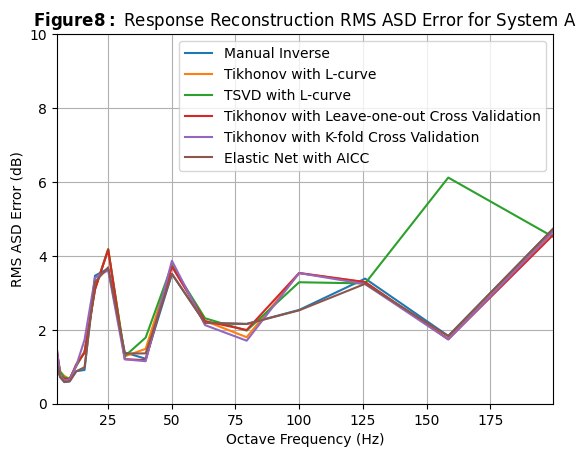

In [11]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)
plt.figure()
for ii, data in enumerate(rms_asd_error_a):
    plt.plot(data[0], data[1], label=inverse_method_names[ii], color=next(color_cycle))
plt.grid()
plt.legend()
plt.xlabel('Octave Frequency (Hz)')
plt.ylabel('RMS ASD Error (dB)')
plt.title('$\\bf{Figure 8:}$ Response Reconstruction RMS ASD Error for System A')
plt.xlim(left=data[0].min(), right=data[0].max())
plt.ylim(top=10, bottom=0)

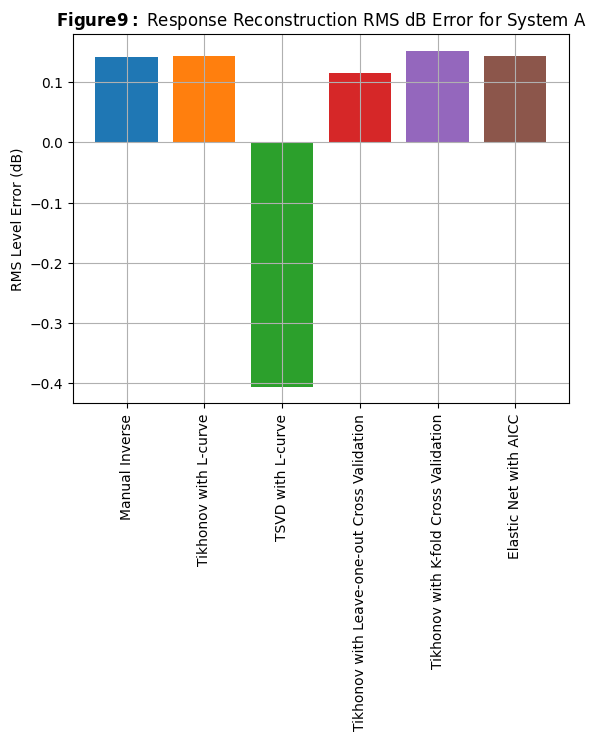

In [12]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)
bar_colors = [next(color_cycle) for ii in range(len(inverse_method_names))]
plt.figure()
plt.bar(inverse_method_names, rms_level_error_a, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel('RMS Level Error (dB)')
plt.title('$\\bf{Figure 9:}$ Response Reconstruction RMS dB Error for System A')
plt.grid()

## Response Reconstruction Accuracy on System B
The RMS ASD error for system B is shown in Figure 10 and the RMS dB error is shown in Figure 11.

(0.0, 70.0)

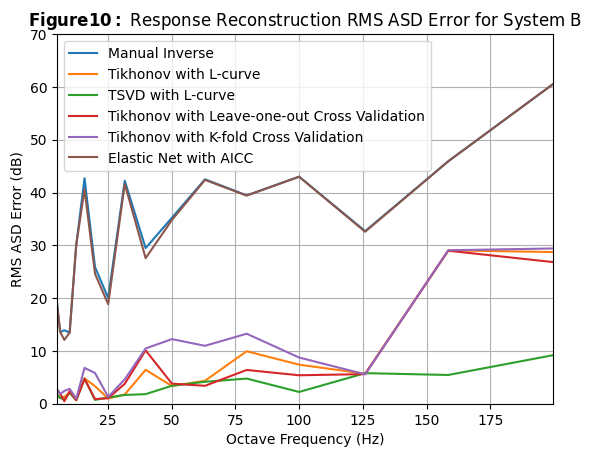

In [16]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)
plt.figure()
for ii, data in enumerate(rms_asd_error_b):
    plt.plot(data[0], data[1], label=inverse_method_names[ii], color=next(color_cycle))
plt.grid()
plt.legend()
plt.xlabel('Octave Frequency (Hz)')
plt.ylabel('RMS ASD Error (dB)')
plt.title('$\\bf{Figure 10:}$ Response Reconstruction RMS ASD Error for System B')
plt.xlim(left=data[0].min(), right=data[0].max())
plt.ylim(top=70, bottom=0)

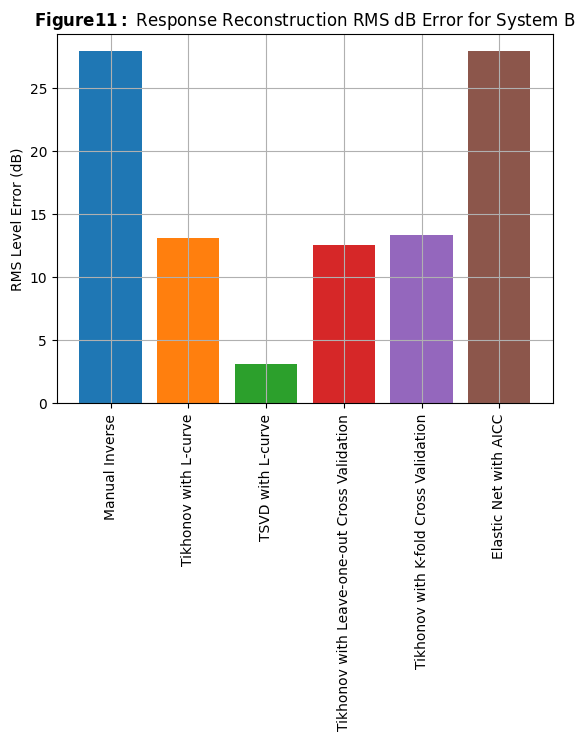

In [14]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)
bar_colors = [next(color_cycle) for ii in range(len(inverse_method_names))]
plt.figure()
plt.bar(inverse_method_names, rms_level_error_b, color=bar_colors)
plt.xticks(rotation=90)
plt.ylabel('RMS Level Error (dB)')
plt.title('$\\bf{Figure 11:}$ Response Reconstruction RMS dB Error for System B')
plt.grid()

## Force Amplitude 
The force amplitude comparison for the different inverse methods is shown in Figure 12. 

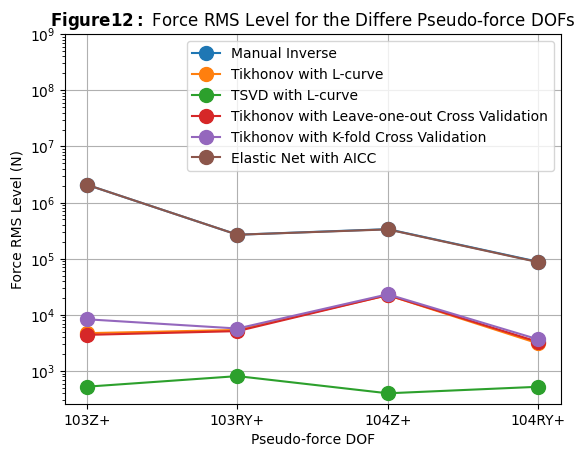

In [15]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)
plt.figure()
for ii, data in enumerate(force_rms_level):
    plt.semilogy(np.arange(4)+1, data, label=inverse_method_names[ii], marker='o', markersize=10, color=next(color_cycle))
plt.ylabel('Force RMS Level (N)')
plt.xlabel('Pseudo-force DOF')
plt.title('$\\bf{Figure 12:}$ Force RMS Level for the Differe Pseudo-force DOFs')
plt.ylim(top=10e8)
plt.grid()
plt.legend()
plt.xticks(np.arange(4)+1, system_a_spr.reference_coordinate.string_array());